In [4]:
from mangaki.utils.common import RecommendationAlgorithm
from mangaki.utils.data import Dataset
from mangaki.utils.recommendations import rating_values
from mangaki.utils.als import MangakiALS
from scipy.sparse import coo_matrix, load_npz
from sklearn.model_selection import ShuffleSplit, GroupShuffleSplit
from numpy.linalg import cond
from collections import defaultdict
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import binarize
import scipy.sparse as sp
from numpy.matlib import repmat
from scipy.sparse.linalg import spsolve
from scipy.sparse import kron
from scipy.spatial.distance import cdist
import numpy as np
import logging
import gc

In [5]:
REG_THRESHOLD = 0


def relu(x):
    return max(-2, min(2, x))

In [13]:
class MangakiBALSE(RecommendationAlgorithm):
    M = None
    U = None
    VT = None

    def __init__(self, NB_COMPONENTS=10, NB_ITERATIONS=10, LAMBDA=0.1, a=0.05, b=0.2):
        super().__init__()
        self.NB_COMPONENTS = NB_COMPONENTS
        self.NB_ITERATIONS = NB_ITERATIONS
        self.LAMBDA = LAMBDA
        self.a = a
        self.b = b

    @staticmethod
    def load_tags(T=None):
        # From file
        if T is None:
            T = load_npz('../code/data/balse/weighted_tags.npz').toarray()
        _, nb_tags = T.shape
        
        return T, nb_tags

    def create_appropriate_model(self, n_samples):
        if n_samples <= 3:
            return LinearRegression(), False
        else:
            alpha = self.a + self.b
            l1_ratio = self.a / alpha
            return ElasticNet(alpha=alpha, positive=True, l1_ratio=l1_ratio), False
            # return LassoLars(alpha=0.05)
    
    @staticmethod
    def make_link_matrix(T):
        # return pairwise_jaccard_sparse(binarize(T), 0.6)
        return pairwise_distances(sp.csr_matrix(binarize(T)), metric='l2', n_jobs=-2)
    
    def fit_als(self, X, y):
        self.als = MangakiALS(self.NB_COMPONENTS, self.NB_ITERATIONS, self.LAMBDA)
        self.als.set_parameters(self.nb_users, self.nb_works)
        self.als.fit(X, y)
        return self.als.predict(X)
    
    def warm_start_als(self, als, X):
        self.als = als
        return self.als.predict(X)

    def fit(self, X, y, warm_start = None):
        self.T, self.nb_tags = self.load_tags()
        print('Cond number for T: {:f}'.format(cond(self.T)))
        print(self.T.shape)
        
        if warm_start is None:
            y_pred = self.fit_als(X, y)
        else:
            y_pred = self.warm_start_als(warm_start, X)
        
        row = X[:, 0]
        col = X[:, 1]
        data = y - y_pred
        
        M_res = coo_matrix((data, (row, col)), shape=(self.nb_users, self.nb_works))
        print(M_res)
        M_res = M_res.tocsr()
        
        self.encountered_works = X[:, 1]
        self.reg = {}
        user_ids = sorted(set(row))
        self.r2_scores = [0] * len(user_ids)
        self.cond_numbers = [0] * len(user_ids)
        
        for index, user_id in enumerate(user_ids):
            indices = M_res[user_id].indices
            values = M_res[user_id].data
            n_samples = len(indices)
            
            self.cond_numbers[index] = cond(self.T[indices])
            
            if user_id not in self.reg:
                self.reg[user_id], is_local = self.create_appropriate_model(n_samples)

            self.reg[user_id].fit(self.T[indices], values)

            score = self.reg[user_id].score(self.T[indices], values)
            self.r2_scores[index] = score
            if score < REG_THRESHOLD:  # Ignore dangerous regressions.
                del self.reg[user_id]

            if user_id % 100 == 0:
                print(user_id)

    def predict(self, X):
        # return self.M[X[:, 0].astype(np.int64), X[:, 1].astype(np.int64)] + self.means[X[:, 0].astype(np.int64)]
        y_pred = self.als.predict(X)
        y_delta_res = []
        # R = self.make_link_matrix(X)
        mean_error_reconstruction = np.mean(
            [self.reg[user_id].predict(self.T[work_id].reshape(1, -1))
            for user_id, work_id in X if user_id in self.reg]
        )
        for user_id, work_id in X:
            if user_id not in self.reg:
                print(user_id, 'not')
                y_delta_res.append(mean_error_reconstruction)
            else:
                prediction = np.mean(self.reg[user_id].predict(self.T[work_id].reshape(1, -1)))
                y_delta_res.append(prediction)

        cold_works = np.setdiff1d(X[:, 1], self.encountered_works)
        print('{}-Item cold-start. ({} % cold)'.format(
            len(cold_works), (len(cold_works)/len(X[:, 1]))*100
        ))

        return np.clip(y_pred + y_delta_res, -0.5, 4)

    def get_shortname(self):
        return 'balse-%d' % self.NB_COMPONENTS

In [7]:
class Research:
    @staticmethod
    def load_dataset(dataset_name):
        dataset = Dataset()
        dataset.load_csv(
            dataset_name,
            lambda choice: rating_values[choice]
        )
        return dataset
    
    @staticmethod
    def make_item_groups(X):
        return X[:, 1]

    @staticmethod
    def make_user_groups(X):
        return X[1, :]

In [8]:
dataset = Research.load_dataset('ratings.csv')

In [15]:
k_fold = GroupShuffleSplit(n_splits=3)

balse_instances = []
means = defaultdict(list)
item_groups = Research.make_item_groups(dataset.anonymized.X)
for i_train, i_test in k_fold.split(dataset.anonymized.X, dataset.anonymized.y, item_groups):
    als = MangakiALS(NB_COMPONENTS=10, LAMBDA=0.2)
    als.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
    als.fit(dataset.anonymized.X[i_train], dataset.anonymized.y[i_train])
    
    balse = MangakiBALSE(NB_COMPONENTS=10, LAMBDA=0.2)
    balse.set_parameters(dataset.anonymized.nb_users, dataset.anonymized.nb_works)
    balse.fit(dataset.anonymized.X[i_train], dataset.anonymized.y[i_train], als)
    
    balse_y_pred = balse.predict(dataset.anonymized.X[i_test])
    als_y_pred = als.predict(dataset.anonymized.X[i_test])
    
    balse_rmse = balse.compute_rmse(balse_y_pred, dataset.anonymized.y[i_test])
    als_rmse = als.compute_rmse(als_y_pred, dataset.anonymized.y[i_test])
    
    print('Was: {}'.format(dataset.anonymized.y[i_test]))
    for y_pred, rmse in zip((balse_y_pred, als_y_pred), (balse_rmse, als_rmse)):        
        print('Predicted: {}'.format(y_pred))
        print('RMSE={:f}'.format(rmse))
    
    print('BALSE diagnostic:')
    print('Condition number={:f}'.format(np.mean(balse.cond_numbers)))
    print('R^2 score={:f}'.format(np.mean(balse.r2_scores)))
    balse_instances.append(balse)
    
    means['balse'].append(balse_rmse)
    means['als'].append(als_rmse)
    
    gc.collect()

print('BALSE: RMSE={:f}, R^2 score={:f}'.format(np.mean(means['balse']), np.mean([np.mean(instance.r2_scores) for instance in instances])))
print('ALS: RMSE={:f}'.format(np.mean(means['als'])))

Computing M: (2264 × 15663)
Chrono: fill and center matrix [0q, 6962ms]
Shapes (2264, 10) (10, 15663)
Chrono: factor matrix [0q, 91591ms]
Cond number for T: 2434.048621
(15663, 503)
  (676, 6392)	-3.11889999118
  (416, 3621)	1.05088852036
  (2199, 13035)	1.44864612938
  (499, 10502)	0.841165206468
  (70, 10424)	0.406049779022
  (2226, 4140)	-0.722300404786
  (624, 226)	0.266411335123
  (1413, 15541)	-0.77181766783
  (1794, 3388)	-0.375363206757
  (1799, 12253)	0.0795611601991
  (1720, 8940)	-1.74465143779
  (1250, 8635)	0.826562868683
  (878, 5036)	0.499522590695
  (764, 3705)	0.419666350545
  (813, 12801)	0.54943523897
  (2225, 3029)	0.49086855277
  (1117, 10157)	1.54646248713
  (1484, 2416)	1.13560682454
  (1186, 9325)	-0.272378183792
  (584, 13234)	-0.917445599099
  (697, 8248)	-2.76505693364
  (2085, 9596)	1.4593000469
  (1506, 4746)	2.22146894629
  (331, 2485)	-0.152372949151
  (373, 15339)	-0.0357881069387
  :	:
  (1808, 2880)	-1.51976815516
  (427, 482)	-0.87680894976
  (971, 14

In [16]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [17]:
from sklearn.decomposition import PCA
def plot_pca_of_reg_lins(instance):
    coeffs = np.array([reg.coef_ for reg in instance.reg.values()])
    pca = PCA(n_components=2)
    reduced_coeffs = pca.fit_transform(coeffs)
    print ('Explanied variance ratio: {}'.format(pca.explained_variance_ratio_))
    
    plt.plot(reduced_coeffs[:,0], reduced_coeffs[:,1])

Explanied variance ratio: [ 0.30236238  0.10136952]
Explanied variance ratio: [ 0.22775693  0.12103242]
Explanied variance ratio: [ 0.30943899  0.1923255 ]


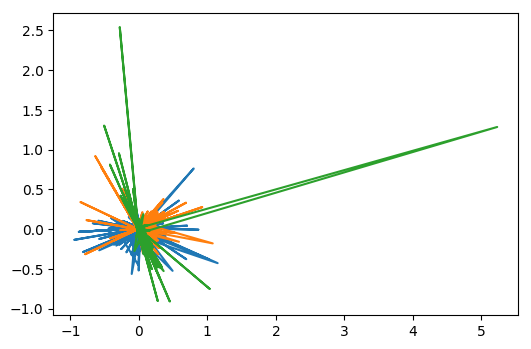

In [18]:
for instance in instances:
    plot_pca_of_reg_lins(instance)